# Lab-based Group Assignment 3: 
## Signature Authentication to Prevent Fraud Transactions in Business



![Imgur](https://i.imgur.com/4HJknC2.png)

### **Business Problem**
In a legal context, a signature is your name written in a distinct, personalized form as a way of identifying yourself to authorize a document. Using signiture for identity validation is still a global-wide practice for legal authentication.

In order to **prevent fraud transactions, a bank’s established practice** is to compare the signature on a request to the signature maintained in the bank’s file system and to confirm that the request is issued by the correct issuer.

Without modern signiture authentication technology, banks around the world had suffered huge losses against fraud transaction in which  signitures are maliciously forged.
\
\
(Optional) Read More about a real-life signiture-related legal case:  
<a href="http://www.joneslemongraham.com/blog/banks-loss-a-covered-forgery-under-insuring-agreement-d-of-financial-institution-bond-and-not-excluded-by-loan-loss-exclusion/#.X2bDBy9h1PM">Bank of Ann Arbor v. Everest National Insurance Company, Case No. 12-11251 (E.D. Mi. Feb. 25, 2013)</a>
\
\
Luckily, we have advanced computer vision technology, which can conveniently and accurately identify forged signitures.


![Imgur](https://i.imgur.com/f9Ozq9M.png)

<img src="https://storage.googleapis.com/kaggle-datasets-images/107946/257611/57ea0c6f63a05a981b18eb7ad5547464/dataset-cover.png?t=2019-01-20-18-39-59">

### **Task**
Build a deep learning model to classify forged signatures from genuine signitures to prevent fraud transactions in businesses. 

---

In [ ]:
# First things first: Please select a GPU backend.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
Click the folder button on the left, and Colab will display a file window. (Probably you might have to wait for at most 10 seconds, before the `drive` folder shows up.) Find the zip file `signature-verification-dataset.zip` under the drive folder.  

Right click the file and select "copy path". Now the file path is on your clip board. Paste the path inside the double quote in the next code chunk.

## Q1: Please unzip, read and seperate the dataset for the model?

In [3]:
# Unzip signature-verification-dataset.zip to "/content" directory. 
!unzip -q "/content/drive/MyDrive/DAT565E Deep Learning/Week 3/signature-verification-dataset(1).zip" -d /content/

In [33]:
import pandas as pd
# Load data
train_df=pd.read_csv("/content/sign_data/train_data.csv",header=None,usecols=[1,2],names=["file_name","forged"],dtype=str)
test_df=pd.read_csv("/content/sign_data/test_data.csv",header=None,usecols=[1,2],names=["file_name","forged"],dtype=str)

# Train Test Split
from sklearn.model_selection import train_test_split
train_df, validation_df=train_test_split(train_df,train_size=0.8)
print(train_df.shape,validation_df.shape,test_df.shape)

(18564, 2) (4642, 2) (5748, 2)


In [34]:
display(train_df)
# See how many genuine/forged signitures in train data?
train_df.forged.value_counts()

,file_name,forged
4363,014/014_14.PNG,0
22061,037/08_037.png,0
14280,016_forg/0202016_02.png,1
22868,066/10_066.png,0
12234,050/07_050.png,0
...,...,...
7897,009/009_03.PNG,0
5045,012/012_06.PNG,0
22520,061_forg/03_0102061.PNG,1
9084,001/001_18.PNG,0


0    10094
1     8470
Name: forged, dtype: int64

In [35]:
# Define the data path, we will use it later.
path="/content/sign_data/"

In [36]:
# The mode of image
from PIL import Image
Image.open("/content/sign_data/train/001/001_01.PNG").mode

'RGB'

## Q2: Please generate new dataset by using ImageDataGenerator

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Instantiate ImageDataGenerator class
train_datagen = ImageDataGenerator(rescale=1./255)

# Configure train data generator
train_gen=train_datagen.flow_from_dataframe( 
    train_df,                                   # Pandas dataframe containing the filepaths relative to directory (or absolute paths if directory is None) of the images in a string column.
    directory="/content/sign_data/train",       # string, path to the directory to read images from. If None, data in x_col column should be absolute paths.
    x_col="file_name",                          # string, column in dataframe that contains the filenames (or absolute paths if directory is None).
    y_col="forged",                             # string or list, column/s in dataframe that has the target data.
    target_size=(128, 256),                     # tuple of integers (height, width), default: (256, 256). The dimensions to which all images found will be resized. 
    color_mode="rgb",                           # one of "grayscale", "rgb", "rgba". Default: "rgb". Whether the images will be converted to have 1 or 3 color channels.
    class_mode="binary",                        # one of "binary", "categorical", "input", "multi_output", "raw", sparse" or None. Default: "categorical". If y_col is a binary class (0 or 1), you should use "binary". If y_col is numeric value array, you should use "raw".
    batch_size=32,   # size of the batches of data (default: 32). This batchsize is different from the one in model.fit(). It is just another batchsize served for converting original images to executable format for neural network.
    shuffle=True)                               # whether to shuffle the data (default: True). This is for eliminating bias in generating input data

# Configure validation data generator
val_datagen = ImageDataGenerator(rescale=1./255)
val_gen=val_datagen.flow_from_dataframe(
    validation_df,
    directory="/content/sign_data/train",
    x_col="file_name",
    y_col="forged",
    target_size=(128, 256),
    color_mode="rgb",
    class_mode="binary",
    ) #In the generation of validation and test dataset, its not necessary to define batchsize and shuffle. Because only training dataset is taken for training.

# Configure test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen=test_datagen.flow_from_dataframe(
    test_df,
    directory="/content/sign_data/test",
    x_col="file_name",
    y_col="forged",
    target_size=(128, 256),
    color_mode="rgb",
    class_mode="binary",
    )

Found 18564 validated image filenames belonging to 2 classes.
Found 4642 validated image filenames belonging to 2 classes.
Found 5748 validated image filenames belonging to 2 classes.


## Q3: Please use dense neural networks for predict the forged signatures. 

In [38]:
# Build sequential model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
model=Sequential()
model.add(Flatten())   # Flatten the channels into one single long array
model.add(Dense(2048 ,input_shape = (128*256*3,) ,activation = 'relu'))     
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['acc'])

history=model.fit(train_gen,                                # Train data generator
      steps_per_epoch=100,    #train_gen.n//train_gen.batch_size. In lab 2, we set "batchsize" in model.fit() to determine the step length for steps in one epoch. 
                  #Steps_per_epoch is the number of steps in one epoch. It can also determine the step length (batchszie) in each epoch. So, we can set steps_per_epoch instead to replace "batchsize".
                  #Either batchsize or steps_per_epoch is fine. Just make sure you set one of them.
      epochs=10,                                             
      validation_data=val_gen,                              # Validation data generator                      
      validation_steps=100)       # val_gen.n//val_gen.batch_size, Need to sepcify this parameter.        "//" means get the integer part from division result.

Epoch 1/10
100/100 [==============================] - 35s 348ms/step - loss: 27.1163 - acc: 0.5288 - val_loss: 0.8140 - val_acc: 0.4628
Epoch 2/10
100/100 [==============================] - 25s 254ms/step - loss: 3.8495 - acc: 0.5113 - val_loss: 0.6485 - val_acc: 0.7100
Epoch 3/10
100/100 [==============================] - 34s 345ms/step - loss: 1.2265 - acc: 0.5225 - val_loss: 0.7570 - val_acc: 0.5406
Epoch 4/10
100/100 [==============================] - 25s 255ms/step - loss: 0.7579 - acc: 0.5378 - val_loss: 0.6838 - val_acc: 0.5428
Epoch 5/10
100/100 [==============================] - 35s 346ms/step - loss: 0.7175 - acc: 0.5253 - val_loss: 0.8064 - val_acc: 0.5378
Epoch 6/10
100/100 [==============================] - 26s 257ms/step - loss: 0.6874 - acc: 0.5347 - val_loss: 0.7690 - val_acc: 0.4594
Epoch 7/10
100/100 [==============================] - 25s 252ms/step - loss: 0.6975 - acc: 0.5312 - val_loss: 0.6838 - val_acc: 0.5344
Epoch 8/10
100/100 [==============================] - 

## Q4: Please use CNNs to predict the forged signatures with high accuracy. 

### Larger Convolution Model

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, Callback 

# Build sequential model
model=Sequential()
model.add(Conv2D(128, 3,input_shape=(128,256,3),activation="relu"))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, 3,activation="relu"))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dropout(0.5))                                                         # Add Dropout layer, randomly drops 50% neurons from propagation.
model.add(Dense(64,activation="relu", kernel_regularizer="l2"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['acc'])

# Configure EarlyStopping object
Es=EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)      # EarlyStopping with patience 2: if in 2 consecutive epochs, the validation loss didn't hit the record, training will stop.

# Fit the model and record the training history for plotting purpose
history=model.fit(train_gen,
      steps_per_epoch=100, #train_gen.n//train_gen.batch_size. In lab 2, we set "batchsize" in model.fit() to determine the step length for steps in one epoch. 
                  #Steps_per_epoch is the number of steps in one epoch. It can also determine the step length (batchszie) in each epoch. So, we can set steps_per_epoch instead to replace "batchsize".
                  #Either batchsize or steps_per_epoch is fine. Just make sure you set one of them.
      epochs=10,
      validation_data=val_gen,
      validation_steps=100, #val_gen.n//val_gen.batch_size
      callbacks=[Es])                                                           # Here is how we use EarlyStopping

Epoch 1/10
100/100 [==============================] - 29s 284ms/step - loss: 1.1334 - acc: 0.5516 - val_loss: 0.7381 - val_acc: 0.6797
Epoch 2/10
100/100 [==============================] - 28s 285ms/step - loss: 0.5669 - acc: 0.8553 - val_loss: 0.4503 - val_acc: 0.9241
Epoch 3/10
100/100 [==============================] - 28s 280ms/step - loss: 0.4199 - acc: 0.9262 - val_loss: 0.4722 - val_acc: 0.8766
Epoch 4/10
100/100 [==============================] - 29s 287ms/step - loss: 0.3207 - acc: 0.9488 - val_loss: 0.2798 - val_acc: 0.9369
Epoch 5/10
100/100 [==============================] - 28s 285ms/step - loss: 0.2515 - acc: 0.9428 - val_loss: 0.1688 - val_acc: 0.9787
Epoch 6/10
100/100 [==============================] - 28s 283ms/step - loss: 0.1880 - acc: 0.9612 - val_loss: 0.1353 - val_acc: 0.9809
Epoch 7/10
100/100 [==============================] - 28s 280ms/step - loss: 0.1433 - acc: 0.9722 - val_loss: 0.1068 - val_acc: 0.9853
Epoch 8/10
100/100 [==============================] - 2

In [40]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 126, 254, 128)     3584      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 63, 127, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 61, 125, 64)       73792     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 30, 62, 64)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 119040)            0         
                                                                 
 dropout_6 (Dropout)         (None, 119040)           

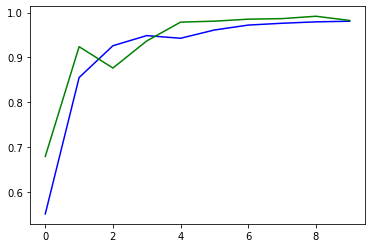

In [41]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='g')
plt.show()

In [42]:
# Evaluate test data accuracy.
model.evaluate(test_gen)

180/180 [==============================] - 25s 141ms/step - loss: 0.1314 - acc: 0.9708


[0.1314014345407486, 0.9707724452018738]

### Underfitting and Overfitting

![Imgur](https://i.imgur.com/pQedNv0.png)

### Convolution Model

In [43]:
# Final version
# Build sequential model
model=Sequential()
model.add(Conv2D(128, 3,input_shape=(128,256,3),activation="relu"))
model.add(MaxPooling2D(2))
#model.add(Conv2D(64, 3,activation="relu"))
#model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dropout(0.5))                                                         # Add Dropout layer, randomly drops 50% neurons from propagation.
model.add(Dense(64,activation="relu", kernel_regularizer="l2"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=['acc'])

# Configure EarlyStopping object
Es=EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)      # EarlyStopping with patience 2: if in 2 consecutive epochs, the validation loss didn't hit the record, training will stop.

# Fit the model and record the training history for plotting purpose
history=model.fit(train_gen,
      steps_per_epoch=100, #train_gen.n//train_gen.batch_size
      epochs=10,
      validation_data=val_gen,
      validation_steps=100, #val_gen.n//val_gen.batch_size
      callbacks=[Es])                                                           # Here is how we use EarlyStopping

Epoch 1/10
100/100 [==============================] - 34s 328ms/step - loss: 3.3323 - acc: 0.7166 - val_loss: 1.1208 - val_acc: 0.9438
Epoch 2/10
100/100 [==============================] - 32s 324ms/step - loss: 0.8440 - acc: 0.9159 - val_loss: 0.6939 - val_acc: 0.9375
Epoch 3/10
100/100 [==============================] - 33s 326ms/step - loss: 0.7301 - acc: 0.9219 - val_loss: 0.6822 - val_acc: 0.9506
Epoch 4/10
100/100 [==============================] - 32s 325ms/step - loss: 0.7409 - acc: 0.9275 - val_loss: 0.6622 - val_acc: 0.9503
Epoch 5/10
100/100 [==============================] - 33s 327ms/step - loss: 0.6845 - acc: 0.9362 - val_loss: 0.6028 - val_acc: 0.9634
Epoch 6/10
100/100 [==============================] - 33s 326ms/step - loss: 0.6896 - acc: 0.9441 - val_loss: 0.6513 - val_acc: 0.9616
Epoch 7/10
100/100 [==============================] - 33s 326ms/step - loss: 0.6924 - acc: 0.9428 - val_loss: 0.6047 - val_acc: 0.9594


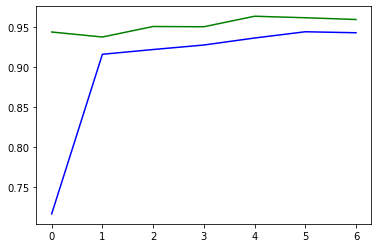

In [44]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='g')
plt.show()

This simple convolution model's performance is similar to dense model. 

###This basic convolution Model

In [45]:
# Intermediate version
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping, Callback

model=Sequential()                                                      
model.add(Conv2D(128, 3,input_shape=(128, 256,3),activation="relu"))     # The first convolution layer: 16 filters with size 3x3.
model.add(MaxPooling2D(2))                                              # Pooling: MaxPooling
model.add(Flatten())                                                    # Flatten the output of pooling layer i.e. create a long array
model.add(Dense(64,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy",                               # This is binary classification
              optimizer="adam",                                         # Adam optimizer
              metrics=['acc'])                                          # Monitoring the accuracy

# Fit the model and record the training history for plotting purpose
history=model.fit(train_gen,
      steps_per_epoch=100, #train_gen.n//train_gen.batch_size
      epochs=10,
      validation_data=val_gen,
      validation_steps=100) #val_gen.n//val_gen.batch_size

Epoch 1/10
100/100 [==============================] - 31s 299ms/step - loss: 1.5089 - acc: 0.7641 - val_loss: 0.1572 - val_acc: 0.9494
Epoch 2/10
100/100 [==============================] - 29s 294ms/step - loss: 0.0962 - acc: 0.9737 - val_loss: 0.0430 - val_acc: 0.9909
Epoch 3/10
100/100 [==============================] - 29s 293ms/step - loss: 0.0218 - acc: 0.9956 - val_loss: 0.0159 - val_acc: 0.9962
Epoch 4/10
100/100 [==============================] - 30s 295ms/step - loss: 0.0157 - acc: 0.9972 - val_loss: 0.0091 - val_acc: 0.9997
Epoch 5/10
100/100 [==============================] - 29s 295ms/step - loss: 0.0040 - acc: 0.9997 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 6/10
100/100 [==============================] - 30s 296ms/step - loss: 9.7197e-04 - acc: 1.0000 - val_loss: 7.3225e-04 - val_acc: 1.0000
Epoch 7/10
100/100 [==============================] - 30s 296ms/step - loss: 6.1161e-04 - acc: 1.0000 - val_loss: 5.0702e-04 - val_acc: 1.0000
Epoch 8/10
100/100 [===================

In [46]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 126, 254, 128)     3584      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 63, 127, 128)     0         
 g2D)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 1024128)           0         
                                                                 
 dense_29 (Dense)            (None, 64)                65544256  
                                                                 
 dense_30 (Dense)            (None, 16)                1040      
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                     

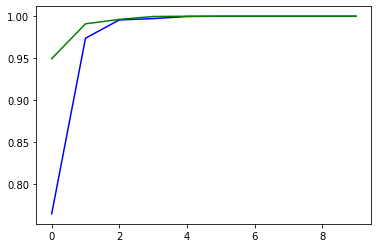

In [47]:
# Plot history
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], color='b')
plt.plot(history.history['val_acc'], color='g')
plt.show()

In [48]:
model.evaluate(test_gen)

180/180 [==============================] - 26s 142ms/step - loss: 2.3039e-04 - acc: 1.0000


[0.00023039108782541007, 1.0]

In [20]:
model.save('/content/modelsign.h5')

At the end, please make sure that you explain how to optimized the parameters and we solved the problem. 

The first model we used is dense neural networks, and the results showed that there might be a underfitting problem due to the low training and validation accuracy rate.  To improve it, we used two convolutional models, and we added drop out and l2 regularization to avoid potential overfitting problems. Indeed, the results showed overall higher accuracy rate and lower loss rate. However, there are gaps between the validation accuracy and the training accuracy, and the reason might be that the drop-out method caused lost of information. The basic convolution model without drop-out helped mitigate this problem, as we can see there are smaller gaps between the validation accuracy and the training accuracy.

If you have any questions, please contact me by using salihtutun@wustl.edu. 

Salih Tutun, Ph.D. 